In [1]:
import io
import os

import fitz  # PyMuPDF
import matplotlib.pyplot as plt
import pandas as pd
from dotenv import load_dotenv
from langchain_community.chat_models import ChatPerplexity
from langchain_core.prompts import ChatPromptTemplate
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from PIL import Image

from langchain.agents.agent_types import AgentType
from langchain.chains import ConversationalRetrievalChain
from langchain.chat_models import ChatOpenAI
from langchain.docstore.document import Document
from langchain.document_loaders import PyMuPDFLoader
from langchain.embeddings import OpenAIEmbeddings
from langchain.memory import ConversationBufferMemory
from langchain.retrievers.re_phraser import RePhraseQueryRetriever

# from langchain.document_loaders import PyPDFLoader
# from langchain.document_loaders import PDFMinerLoader
# from langchain_community.document_loaders import UnstructuredPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS

load_dotenv(verbose=True)

# LLM = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)
LLM = ChatPerplexity(
    temperature=0.7,
    model="llama-3.1-sonar-small-128k-chat"
)

class CustomPyMuPDFLoader(PyMuPDFLoader):
    """metadataを絞ったPyMuPDFLoader。絞らないとクラッシュが発生するため。

    Args:
        PyMuPDFLoader (_type_): _description_
    """
    def load(self, **kwargs):
        doc = fitz.open(self.file_path)
        file_path = self.file_path if self.web_path is None else self.web_path
        documents = []
        for page_number, page in enumerate(doc):
            text = page.get_text(**kwargs)
            metadata = {
                "source": file_path,
                "page": page_number
            }
            documents.append(Document(page_content=text, metadata=metadata))
        doc.close()
        return documents
    
def process_pdf_faiss_index(pdf_path, force_recreate=False):
    # PDFファイル名からインデックスファイル名を生成
    pdf_name = os.path.basename(pdf_path)
    index_file = f"{pdf_name}_faiss_index"

    # OpenAI埋め込みモデルの初期化
    embeddings = OpenAIEmbeddings()

    # インデックスファイルが存在し、強制再作成フラグがFalseの場合
    if os.path.exists(index_file) and not force_recreate:
        print(f"Loading existing FAISS index for {pdf_name}")
        return FAISS.load_local(index_file, embeddings, allow_dangerous_deserialization=True)
    
    # PDFの内容を読み取り
    print(f"Creating new FAISS index for {pdf_name}")
    # PDFを読み込む
    loader = CustomPyMuPDFLoader(pdf_path)
    documents = loader.load()

    # テキストを分割
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=400, chunk_overlap=200)
    documents = text_splitter.split_documents(documents)

    # FAISSインデックスの作成
    vectorstore = FAISS.from_documents(documents, embeddings)
    
    # FAISSインデックスをファイルに保存
    vectorstore.save_local(index_file)
    return vectorstore

def process_pdf(pdf_path, questions):
    # 画像化のためのデータ読み込み
    doc = fitz.open(pdf_path)

    # ベクトルストアを作成、読込
    vectorstore = process_pdf_faiss_index(pdf_path, force_recreate=False)

    # HyDEプロンプトテンプレート
    hyde_prompt_template = """ \
    以下の質問の回答を書いてください。
    質問: {question}
    回答: """
    # HyDE Prompt
    hyde_prompt = ChatPromptTemplate.from_template(hyde_prompt_template)
    # HyDE retriever
    hyde_retriever = RePhraseQueryRetriever.from_llm(
        retriever = vectorstore.as_retriever(),
        llm = LLM,
        prompt = hyde_prompt,
    )

    # # 会話チェーンを作成
    memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
    qa_chain = ConversationalRetrievalChain.from_llm(
        llm=LLM,
        # retriever=vectorstore.as_retriever(),
        retriever=hyde_retriever,
        memory=memory
    )
    
    # 質問に対する回答と関連ページを取得
    results = []
    for question in questions:
        result = qa_chain({"question": question})
        answer = result['answer']
        
        # 関連ページを特定
        relevant_docs = vectorstore.similarity_search(question, k=1)
        relevant_page = relevant_docs[0].metadata.get('page', None)
        
        if relevant_page is not None and 0 <= int(relevant_page) < len(doc):
            relevant_page = int(relevant_page)
            page = doc[relevant_page]
            # 高解像度のピクスマップを取得
            dpi = 300
            zoom = dpi / 72  # 72 DPI is the default PDF resolution
            mat = fitz.Matrix(zoom, zoom)
            pix = page.get_pixmap(matrix=mat, alpha=False)

            img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
            
            # 画像をバイトストリームに保存
            buf = io.BytesIO()
            img.save(buf, format='PNG')
            buf.seek(0)
        else:
            buf = None
    
        results.append({
            "file_name": pdf_path,
            "question": question,
            "answer": answer,
            "relevant_page": relevant_page,
            "image": buf,
        })
    
    doc.close()
    return results


def process_pdfs(pdf_dir, questions):
    all_results = []
    for filename in os.listdir(pdf_dir):
        if filename.endswith('.pdf'):
            pdf_path = os.path.join(pdf_dir, filename)
            print(f"Processing {filename}...")
            results = process_pdf(pdf_path, questions)
            all_results.extend(results)
    return all_results



In [2]:
#　クエリ拡張のサンプル

# from typing import List

# from pydantic import BaseModel, Field

# from langchain.output_parsers import PydanticOutputParser
# from langchain.prompts import ChatPromptTemplate


# # カスタム出力パーサーの定義
# class QueryExpansion(BaseModel):
#     queries: List[str] = Field(description="クエリ展開された3つの質問のリスト")

# parser = PydanticOutputParser(pydantic_object=QueryExpansion)
# prompt = ChatPromptTemplate.from_messages([
#     ("system", """
#     ユーザーの質問を以下のように処理してください：
#     1.クエリの展開：ユーザーの質問に複数の一般的な表現がある場合、それらを含めた形でクエリを展開してください。
#     2.クエリの拡張：関連する可能性のある追加のキーワードや概念を含めて、クエリの範囲を広げてください。
#     3.原文の保持：頭字語（略語）や専門用語などの聞き慣れない単語がある場合、それらを言い換えずにそのまま使用してください。
#     最終的に、元の質問の意図を保ちつつ、3つの異なるバージョンの質問を作成し、提示してください。
#     {format_instructions}
#     """),
#     ("human", "{question}")
# ])
# model = LLM

# # 使用例
# questions = [
#     "AIやデータ利活用、デジタルトランスフォーメーション(DX)の取り組み",
# ]

# query_expansion_chain = prompt | model | parser
# result = query_expansion_chain.invoke({
#     "question": questions[0],
#     "format_instructions": parser.get_format_instructions()
#     })
# print(result)

In [3]:
# 使用例
pdf_path = "ir2024_all_ja.pdf"
pdf_dir = "pdf"
questions = [
    # "中期経営計画について",
    # "ビジネスモデルや成長戦略について",
    # "経営課題やリスク、事業環境の変化に対する対応策について",
    # "主要セグメント、各事業部の現状や目標について",
    # "ESG課題やSDGsへの対応（社会課題の解決や持続可能な社会の実現）",
    "AIやデータ利活用、デジタルトランスフォーメーション(DX)の取り組み",
]

# results = process_pdf(pdf_path, questions)
results = process_pdfs(pdf_dir, questions)

Processing data24d_all_browsing.pdf...


/var/folders/qp/8r0j_1tx1973dzv1g4437jdm0000gp/T/ipykernel_49836/3109023357.py:62: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  embeddings = OpenAIEmbeddings()


Loading existing FAISS index for data24d_all_browsing.pdf


TypeError: 'RePhraseQueryRetriever' object is not callable

質問: AIやデータ利活用、デジタルトランスフォーメーション(DX)の取り組み
回答: みずほ銀行は、AIやデータ利活用、デジタルトランスフォーメーション(DX)の取り組みを以下のように進めています。

### AIの活用
- **AI技術のR&D強化**: 最先端のAI技術を研究開発し、ビジネスに活用しています。
- **生成AIアイデアソン**: 社員からAIに関するアイデアを募集し、特に優秀なアイデアを選定し実現に向けた検討や技術検証を進めています。
- **AI活用の拡大**: AI技術は日進月歩であり、将来的にさらなる活用余地の拡大が期待されています。

### データ利活用・ガバナンス
- **データ利活用の高度化**: データを活用するためのアーキテクチャを一体的に高度化し、体制を強化しています。
- **データガバナンス**: データの利用と管理を規定するガバナンス体制を整備し、データの信頼性と安全性を確保しています。

### ワークスタイルDX
- **ワークスタイルの革新**: ワークスタイルをDX化し、効率化と高度化を目指しています。
- **DXカルチャーの浸透**: DXに取り組むカルチャーを社内に浸透させ、全社的にDX推進を支援しています。

### ビジネス・業務のDX化
- **リソースの集中・最適化**: 領域や案件を戦略的に選定し、リソースを集中・最適化することでDXを加速しています。
  - **お客さま向け**: お客さま利便性の向上を目指しています。
  - **社内業務向け**: 業務の効率化と高度化を目指しています。

### 新規事業創出
- **スタートアップ企業との連携**: スタートアップ企業との連携やコーポレートベンチャーキャピタル（CVC）活用を通じて、他社との協業による新たな価値の創出を目指しています。
- **社員起点の新規事業アイデア**: 社員から新規事業アイデアを発案し、事業化を支援しています。

### DX人材の育成
- **DX人材育成プログラム**: 全社的にDX推進を支援するために、幅広い社員への教育を実施しています。
- **高度な専門性を持ったチームの強化**: デジタル関連の最先端技術を駆使し、高度な専門性を持ったチームを強化しています。

これらの取り組みを通じて、みずほ銀行はデ

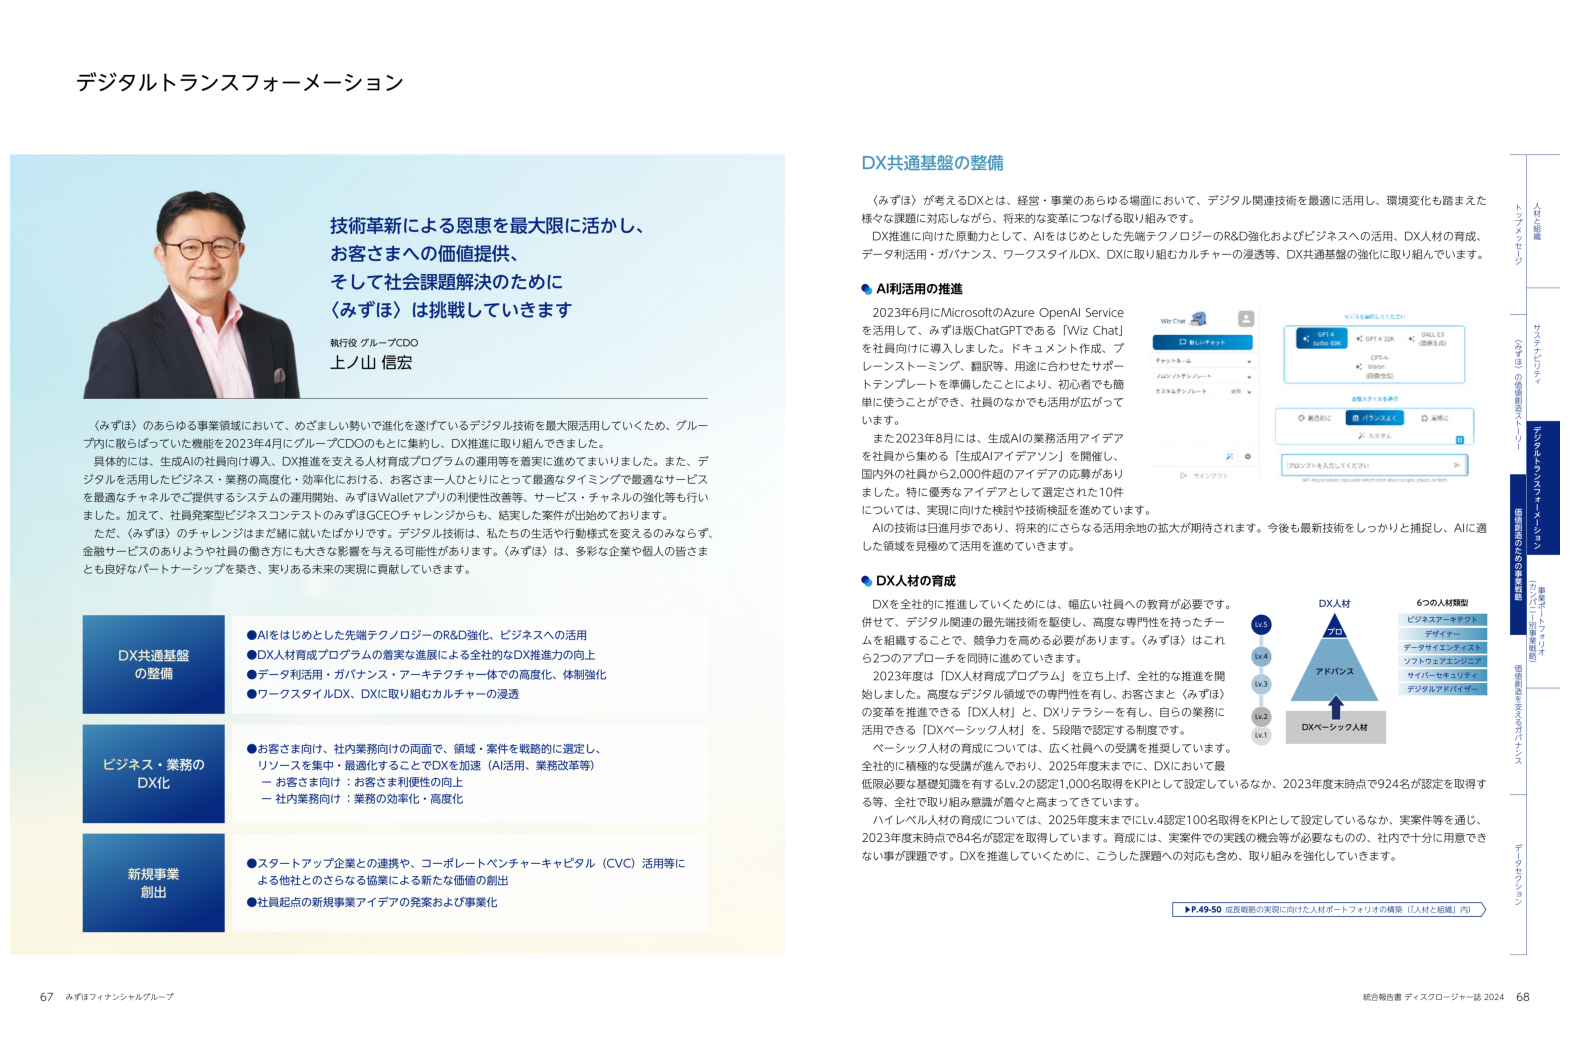

質問: AIやデータ利活用、デジタルトランスフォーメーション(DX)の取り組み
回答: AIやデータ利活用、デジタルトランスフォーメーション(DX)の取り組みについて、以下のような具体的な取り組みが行われています。

1. **AIの活用**:
   - **生成AIの開発**: 生成AIを活用し、文章の意図を解釈し自然な言葉の文章を生成する技術を開発しています。例えば、従業員専用AIアシスタントツール「SMBC-GAI」を開発し、文書作成や照会対応、企画資料作成などに活用しています[1]。

2. **データ利活用**:
   - **分析の高度化**: 電子プラットフォームとの連携を通じた分析の高度化を進めています。これにより、独自性のあるソリューションを提供し、従来とは異なる側面からお客さまの経営戦略をサポートしています[1]。

3. **デジタルトランスフォーメーション(DX)**:
   - **業務効率化支援策**: DXによる業務効率化支援策を検討し、中長期的な視点で継続してアプローチしています。これにより、DXを活用して業務の効率化を進めています[1]。

4. **システム障害の未然防止策**:
   - **コンティンジェンシープランの継続的な改善**: システム障害の未然防止策として、コンティンジェンシープランの継続的な改善や手動による障害対応のシステム化、障害訓練内容の高度化を進めています。これにより、システム障害の影響を極小化するためのレジリエンスを強化しています[1]。

これらの取り組みは、AIやデータ利活用、デジタルトランスフォーメーションを通じて、社会的価値の創造に深くコミットしています。
関連ページ: 40
---


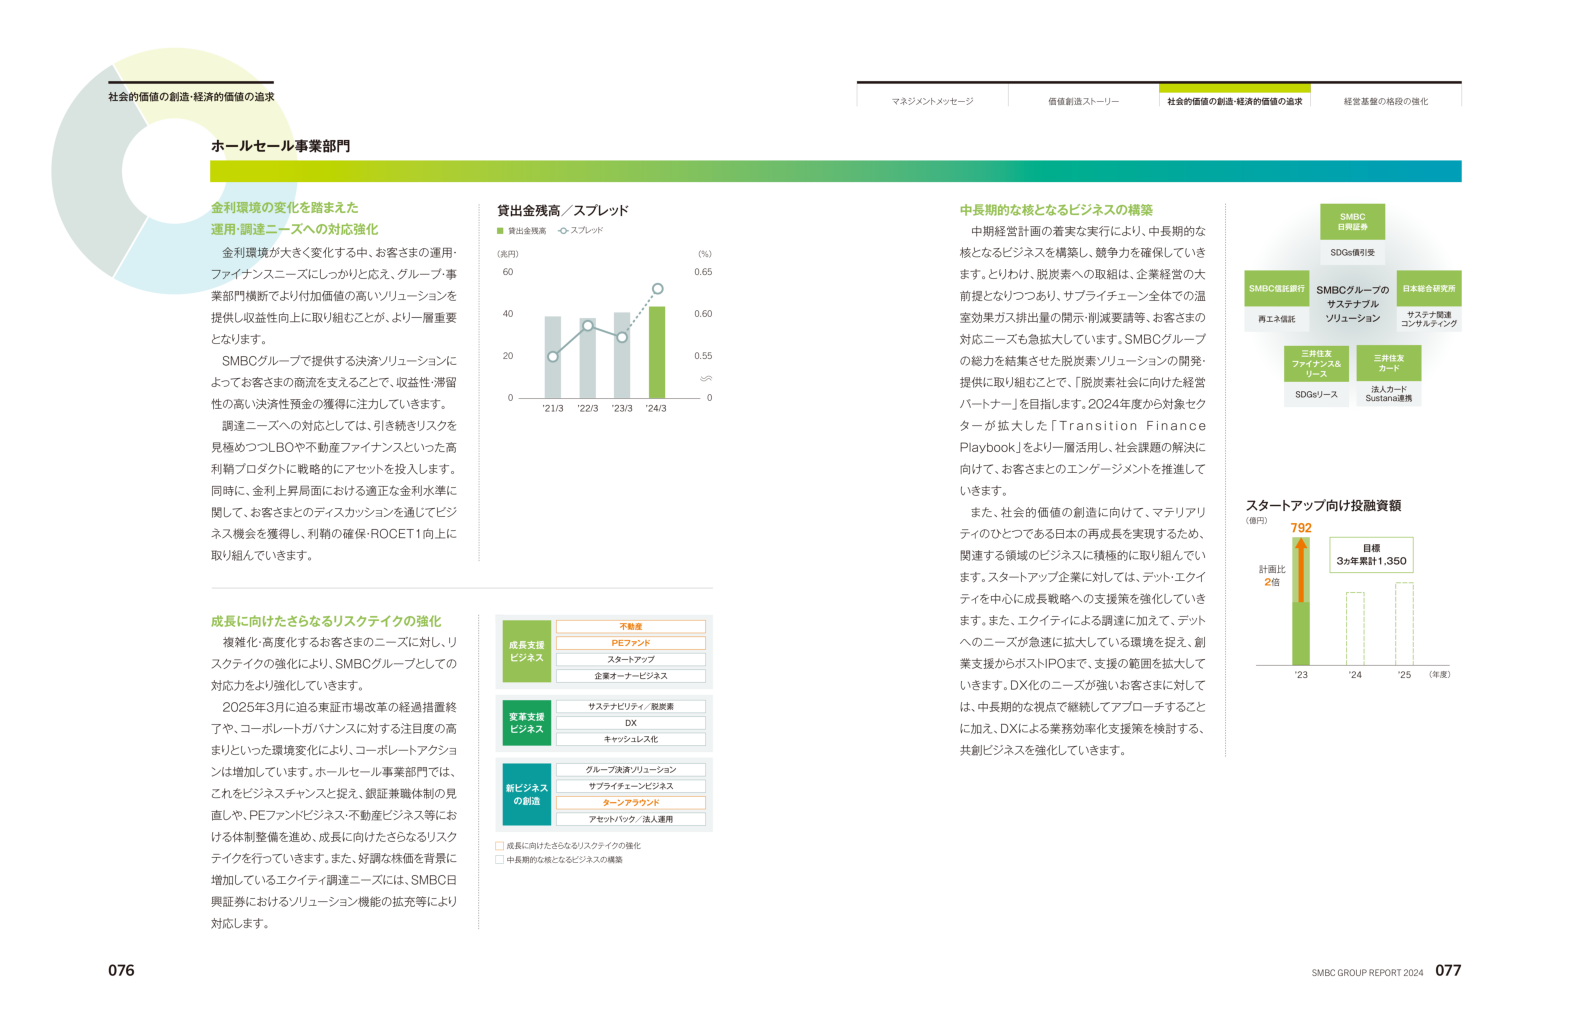

質問: AIやデータ利活用、デジタルトランスフォーメーション(DX)の取り組み
回答: MUFG（三井住友フィナンシャルグループ）におけるAIやデータ利活用、デジタルトランスフォーメーション（DX）の取り組みは、以下の通りです。

### AI・データ基盤の強化
- **データカバレッジ拡大**: AWS上に蓄積したデータのカバレッジを拡大し、基盤を強化することで、データ分析の質と量を向上させています。これにより、サービスや収益力、リスク管理などが向上します[①]。

### 社内コンサルティング機能
- **DX推進のサポート**: DX推進の上流を担う専担者が事業本部や各部と連携し、案件提案などを行うことで、AI・BI等を活用したデジタル施策の推進を強力にサポートしています[②]。

### AIインテリジェンス
- **海外の先進的なAI技術の開発企業や研究機関とのネットワーク構築**: 海外の先進的なAI技術の開発企業や研究機関とのネットワークを構築し、情報収集を行っています。また、国内外の金融機関とユースケースなどの情報交換を行い、AI活用を加速させています[③]。

### 全社的なDX機能とデータ機能の一体化
- **AI・データの利活用**: AI・データの利活用やデジタル起点の事業創出・機能開発の強化に取り組んでいます。これにより、データドリブン経営の実現、顧客価値向上、生産性向上を目指しています[③]。

### 主要施策の概要
- **AI・データ基盤の強化**: AI・データ基盤を強化し、全社員にAI・データ利活用を浸透・習慣化させることで、データドリブン経営の実現、顧客価値向上、生産性向上を目指しています。また、AIインテリジェンス活動により幅広い情報収集を行い、先進技術の探索・利活用を追求しています[③]。

### 主要施策への取り組み
- **開発要員の増強**: 開発要員の増強や、事業部とITの協働強化、エキスパート人材の育成・確保など、主要施策への取り組みが行われています[③]。

これらの取り組みにより、MUFGは今後の金融機関の競争力を強化し、企業価値を向上させるための戦略を推進しています。
関連ページ: 60
---


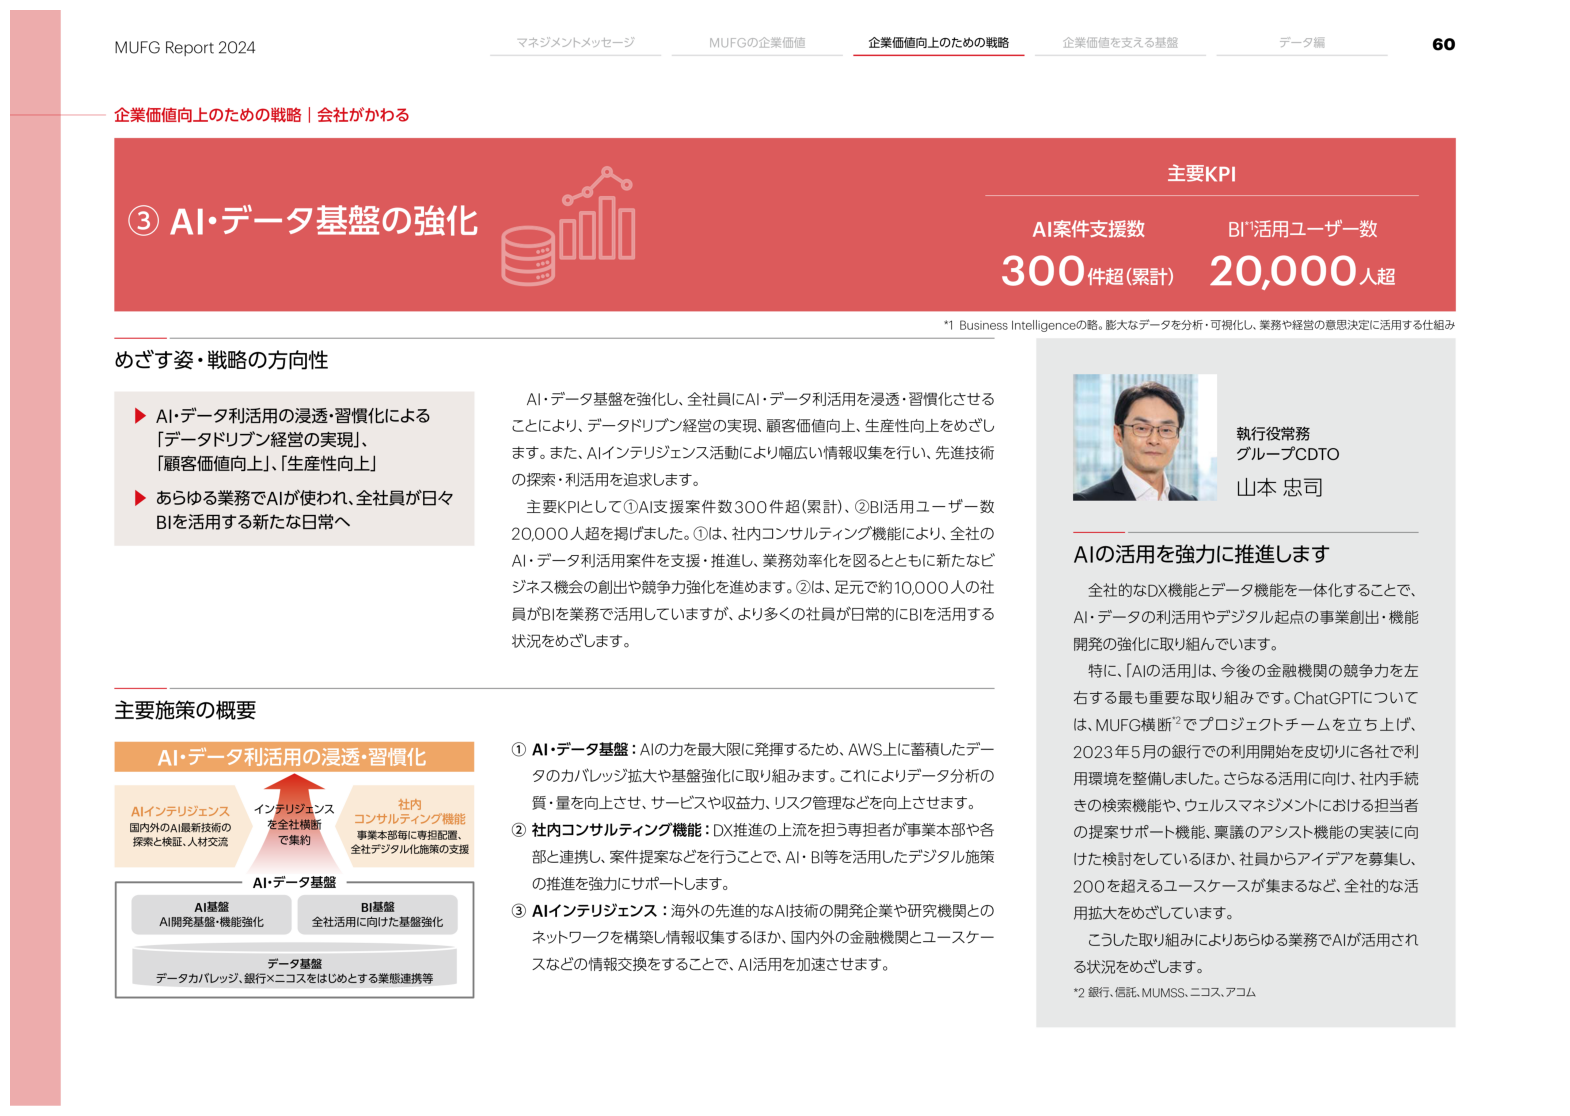

In [7]:
# 結果の表示
for result in results:
    print(f"質問: {result['question']}")
    print(f"回答: {result['answer']}")
    print(f"関連ページ: {int(result['relevant_page']) + 1 if result['relevant_page'] is not None else 'Unknown'}")
    print("---")
    img = Image.open(result['image'])
    plt.figure(figsize=(20, 20))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [5]:

df = pd.DataFrame(results)

pivot_df = pd.pivot_table(df, index='question', columns='file_name', values='answer', aggfunc=lambda x: x.iloc[0])
pivot_df.columns = ['みずほ','SMBC','MUFG']
pivot_df

,file_name,question,answer,relevant_page,image
0,pdf/data24d_all_browsing.pdf,AIやデータ利活用、デジタルトランスフォーメーション(DX)の取り組み,みずほ銀行は、AIやデータ利活用、デジタルトランスフォーメーション(DX)の取り組みを積極的...,34,<_io.BytesIO object at 0x137d75530>
1,pdf/fy2023_f01_00.pdf,AIやデータ利活用、デジタルトランスフォーメーション(DX)の取り組み,この会社は、AIやデータの利活用、デジタルトランスフォーメーション(DX)の取り組みに積極的...,39,<_io.BytesIO object at 0x16d159080>
2,pdf/ir2024_all_ja.pdf,AIやデータ利活用、デジタルトランスフォーメーション(DX)の取り組み,MUFGは、AIやデータ利活用、デジタルトランスフォーメーション(DX)の取り組みを強化して...,59,<_io.BytesIO object at 0x1788ed530>


In [30]:
# 別に無理にcreate_pandas_dataframe_agentを使わなくても良いかも。データ整形してInputすれば良い。
agent = create_pandas_dataframe_agent(
    LLM, pivot_df, verbose=True, allow_dangerous_code=True, agent_type=AgentType.OPENAI_FUNCTIONS,
)
agent_results = agent.invoke("このデータフレームは日本の都市銀行（みずほ、SMBC、MUFG）のquestion行ごとに取り組みの概要が示されています。それぞれの内容を比較して、各行の強みや弱み、それを踏まえての戦略案などまとめてください。")

print(agent_results['output'])



> Entering new AgentExecutor chain...
以下に、各都市銀行の取り組みの概要を比較検討し、強みや弱み、それを踏まえての戦略案をまとめます。

### 1. **みずほ銀行**

**強み:**
- **AI活用の積極性:** AIやデータ利活用を積極的に進めており、AIアイデアソンやWeb上での投資信託提案など新しいビジネスモデル創出に取り組んでいます。
- **データ管理の高度化:** データガバナンスを強化し、データを基にした分析や予測を通じて、ビジネス上の課題に対応しています。
- **DX推進力:** デジタル化推進を通じて、ビジネスを革新し、効率性を向上させています。

**弱み:**
- **具体的な実績の共有不足:** データやAIの活用に関する具体的な実績や成果を共有することが不足しており、信頼性の向上が必要です。

**戦略案:**
- **データ共有の強化:** データ活用に関する具体的な実績や成果を共有することで、信頼性を高め、他社との競争力を向上させることが重要です。
- **AI技術の進化:** AI技術の進化を追随し、最新の技術を早期に導入することで、競争力を高めます。

### 2. **SMBCグループ**

**強み:**
- **DX機能とデータ機能の一体化:** DX機能とデータ機能を一体化することで、AI・データの利活用やデジタル起点の事業創出・機能開発を強化しています。
- **DXベーシック人材の育成:** 「DXベーシック人材」をKPIに設定し、「DX人材育成プログラム」を通じて知識の底上げを図っています。
- **新会社の設立:** 従業員のエンゲージメントやモチベーションをタイムリーに可視化するプラットフォームを提供する新会社を設立しています。

**弱み:**
- **環境への取り組みの具体化:** 環境への取り組みに関する具体的な実績や成果を共有することが不足しており、社会的責任感の向上が必要です。

**戦略案:**
- **環境への取り組みの強化:** 環境への取り組みに関する具体的な実績や成果を共有し、社会的責任感を高めます。
- **DX技術の普及:** DX技術の普及を進めることで、効率性と競争力を向上させることが重要です。

### 3. **MUFG**

**